##### Download, normalize and split vol cube data into train/test datasets

In [1]:
import sys
sys.path.append('../..')  # to go to the main folder of the whole project

from src.data.vol.get_vol_cube_tenors_strikes_dates import get_vol_cube_tenors_strikes_dates
data, uniq_opt_tenors, uniq_swap_tenors, uniq_strikes, dates = get_vol_cube_tenors_strikes_dates()

# Normalize data
from src.data.vol.normalizer import Normalizer
normalizer = Normalizer()
data_norm = normalizer.normalize(data)

# Split train and test datasets
seed = 0 # other seeds provides the same result
from src.utils.get_train_test_datasets import get_train_test_datasets
data_norm_train, dates_train, data_norm_test, dates_test = get_train_test_datasets(data_norm,
                                                                                   dates,
                                                                                   seed=seed,
                                                                                   train_ratio=0.8)

data_train = normalizer.denormalize(data_norm_train)
data_test = normalizer.denormalize(data_norm_test)

##### Load the saved model and its history from the file

In [2]:
from src.utils.load_model_and_history import load_model_and_history

NAME = 'vol_cube_vae_van_2latd_400_200_200_100_3000ep_bat16_2e-06_seed0'
vae, history = load_model_and_history(NAME,
                                      data_type='vol')

c:\Users\alexi\Documents\All\ETH_UZH\MasterThesis\_MT_Vol_cube\code_my\autoencoder_library\venv\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


##### What date has the largest vols?

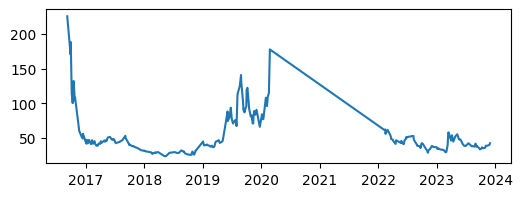

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,2))
plt.plot(dates_test, data_test[:, 2, 0, 0])

In [4]:
# Which date has the maximum vol:
value = data_test.max()  # 226

for i in range(len(data_test)):
    if data_test[i].max() == value:
        print(i, dates_test[i])

0 2016-09-07


### Let's assume that all values except ATM vols will be missed for the date with largest vols

##### Create dataset with missed values

In [5]:
# Create dataset data_norm_test_missed with missed data
import numpy as np
date_idx = 0       # the date that we will investigate
missed_strikes = [0, 1, 2, 4, 5, 6]  # 0 is ATM-100bp, 3 is ATM, 6 is ATM+100bp

# Import what value is considered as a missed value
from references.global_parameters import MISSED_VALUE

# Create dataset with missed values
data_test_missed = data_test.copy()
for missed_stk in missed_strikes:
    data_test_missed[date_idx][:, :, missed_stk] = MISSED_VALUE

# Create normalized dataset with missed values
data_norm_test_missed = data_norm_test.copy()
for missed_stk in missed_strikes:
    data_norm_test_missed[date_idx][:, :, missed_stk] = MISSED_VALUE

##### Draw real data grid and real data grid with missed values

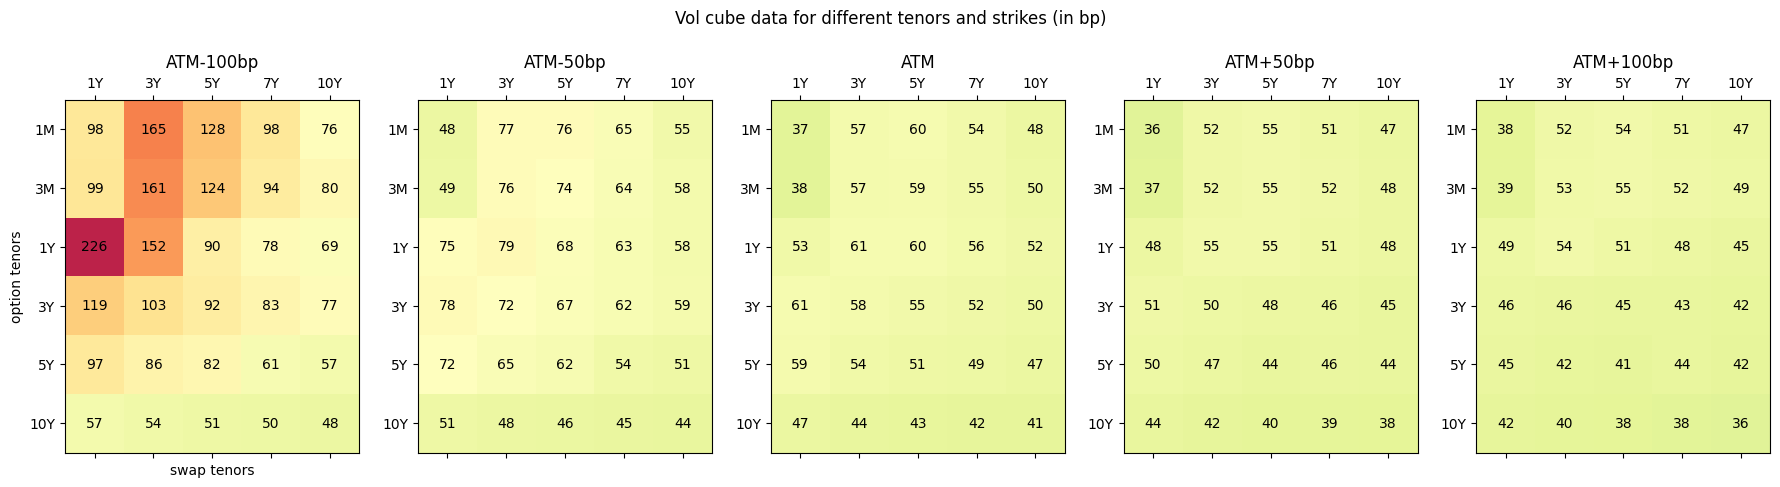

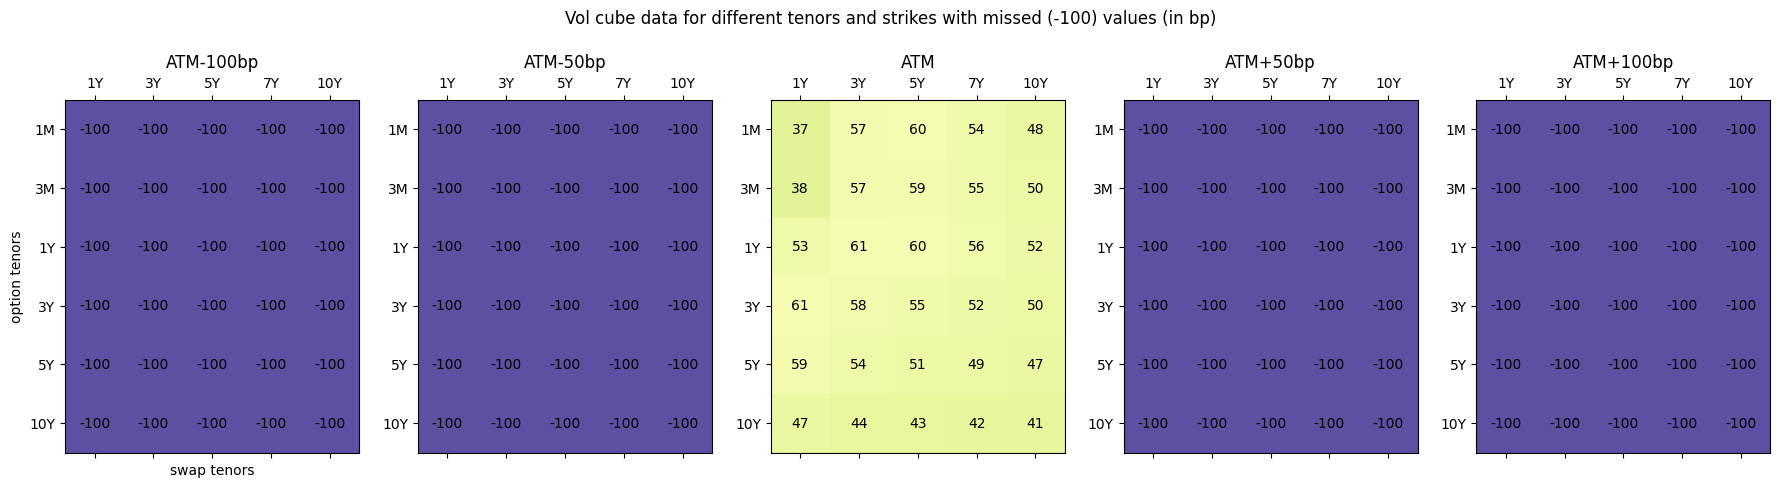

In [6]:
# Draw real data grid
from src.visualization.vol.vol_cube_grids import vol_cube_grids
strikes = ['ATM-100bp', 'ATM-50bp', 'ATM', 'ATM+50bp', 'ATM+100bp']  # graphs only for these strikes
vol_cube_grids(data=data_test[date_idx],
                x_labels=uniq_swap_tenors,
                y_labels=uniq_opt_tenors,
                uniq_strikes=uniq_strikes,
                strikes=strikes,
                save_name=NAME)

# Draw grid of real data with missed values
vol_cube_grids(data=data_test_missed[date_idx],
                x_labels=uniq_swap_tenors,
                y_labels=uniq_opt_tenors,
                uniq_strikes=uniq_strikes,
                strikes=strikes,
                save_name=NAME)

##### Complete the missed data in vol cube and check errors against real data

In [7]:
from src.visualization.vol.find_z_to_complete_vol_cube import find_z_to_complete_vol_cube
z_optimal = find_z_to_complete_vol_cube(vae=vae,
                                        data=data_norm_test_missed[date_idx],
                                        random_attempt_num=30, # number of attempts starting from different random z initial values
                                        random_seed=0,
                                        print_status=True
                                        )

iteration #0
z_initial [3.52810469 0.80031442]
z_optimal [3.40133039 0.53006968]
current mse 0.11474976604415342
best mse 0.11474976604415342
----------------------
iteration #1
z_initial [1.95747597 4.4817864 ]
z_optimal [ 2.36255932 -1.01236619]
current mse 0.06892283976280374
best mse 0.06892283976280374
----------------------
iteration #2
z_initial [ 3.73511598 -1.95455576]
z_optimal [ 0.56538143 -2.49200511]
current mse 0.0005307554332848061
best mse 0.0005307554332848061
----------------------
iteration #3
z_initial [ 1.90017684 -0.30271442]
z_optimal [ 0.56538143 -2.49200511]
current mse 0.06892283884099352
best mse 0.0005307554332848061
----------------------
iteration #4
z_initial [-0.2064377  0.821197 ]
z_optimal [ 0.46741223 -2.86826788]
current mse 0.00020379345773189082
best mse 0.00020379345773189082
----------------------
iteration #5
z_initial [0.28808714 2.90854701]
z_optimal [ 0.46741223 -2.86826788]
current mse 0.06892291993771303
best mse 0.00020379345773189082
----

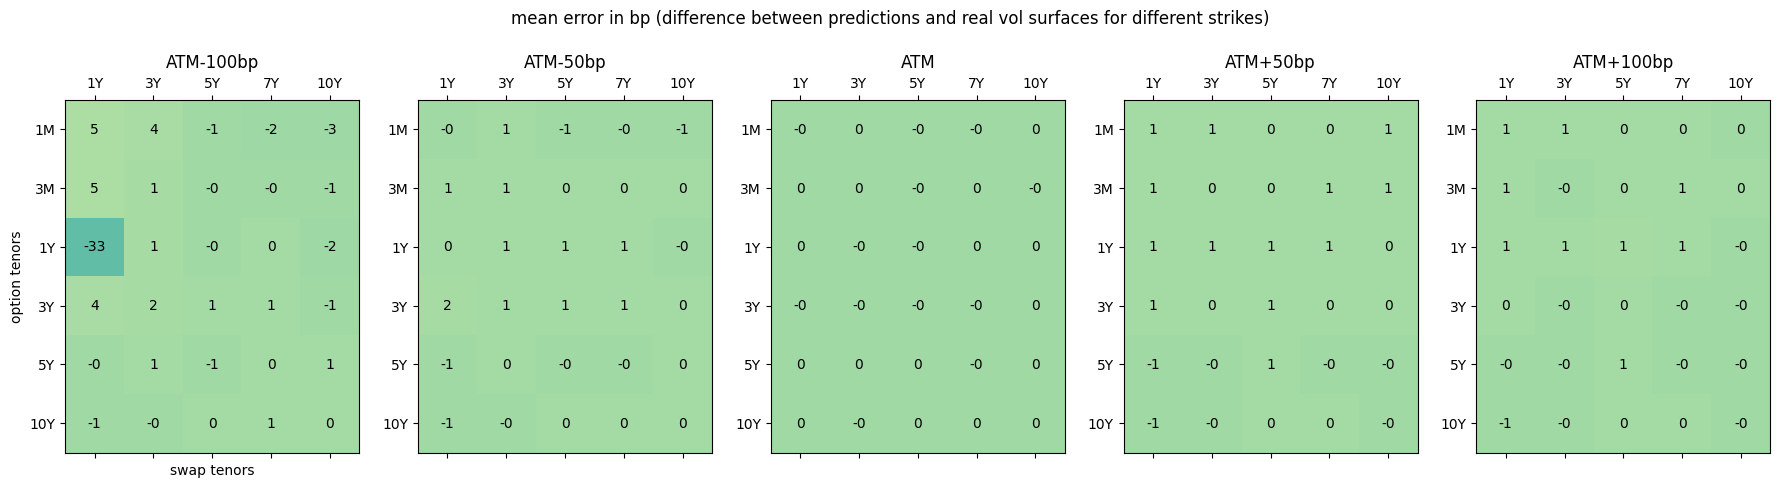

z_real [ 0.27527875 -2.8535213 ]
z_optimal [ 0.46753296 -2.86834723]


In [8]:
# z_optimal = [ 0.46348917, -2.86575929]

from src.visualization.vol.error_vol_cube_grids import error_vol_cube_grids

predictions = normalizer.denormalize(vae.decoder.predict(np.array([z_optimal]), verbose=0))  # shape=(1,6,5,7)

for i in range(predictions.shape[1]):
    for j in range(predictions.shape[2]):
        for k in range(predictions.shape[3]):
            if data_test_missed[date_idx, i, j, k] != MISSED_VALUE:
                predictions[0, i, j, k] = data_test[date_idx, i, j, k]
                
error_vol_cube_grids(predictions=predictions,
                     data=np.expand_dims(data_test[date_idx],0),
                     x_labels=uniq_swap_tenors,
                     y_labels=uniq_opt_tenors,
                     uniq_strikes=uniq_strikes,
                     strikes=strikes,
                     error_type='mean',  # mse, mean or abs_max
                     save_name=NAME
                     )

z_real = vae.encoder.predict(x=np.expand_dims(data_norm_test[date_idx],0), verbose=0)[0][0]
print('z_real', z_real)
print('z_optimal', z_optimal)